# Exercise 4: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [9]:
import pandas as pd
import numpy as np
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [11]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [12]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [13]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [14]:
df_train.head(10)

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [16]:
df_train.isna().sum()

,0
text,0
label,0


4. Check for duplicate rows

In [17]:
df_train.duplicated().sum()

np.int64(0)

5. Check how many rows belong to each class

In [18]:
df_train["label"].value_counts()

,count
label,
1,10994
0,10779


## B. Text pre-processing

6. Remove duplicate rows

In [19]:
df_train = df_train.drop_duplicates()
print("Removed the duplicates:", df_train.shape)

Removed the duplicates: (21773, 2)


7. Remove rows with NaN values

In [20]:
df_train = df_train.dropna()
print("Removed NaN values:", df_train.shape)

Removed NaN values: (21773, 2)


8. Convert all text to lowercase

In [25]:
df_train["clean_text"] = df_train["text"].astype(str).str.lower()
df_train[["text", "clean_text"]].head(10)

,text,clean_text
0,Presidential candidate Mar Roxas implies that ...,presidential candidate mar roxas implies that ...
1,Parang may mali na sumunod ang patalastas ng N...,parang may mali na sumunod ang patalastas ng n...
2,Bet ko. Pula Ang Kulay Ng Posas,bet ko. pula ang kulay ng posas
3,[USERNAME] kakampink,[username] kakampink
4,Bakit parang tahimik ang mga PINK about Doc Wi...,bakit parang tahimik ang mga pink about doc wi...
5,"""Ang sinungaling sa umpisa ay sinungaling hang...","""ang sinungaling sa umpisa ay sinungaling hang..."
6,Leni Kiko,leni kiko
7,Nahiya si Binay sa Makati kaya dito na lang sa...,nahiya si binay sa makati kaya dito na lang sa...
8,Another reminderHalalan,another reminderhalalan
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,[username] maybe because vp leni sen kiko and ...


9. Remove digits, URLS and special characters

In [27]:
import re

def remove_noise(text):
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)
  text = re.sub(r"[^a-z\s]", "", text)
  return text

df_train["clean_text"] = df_train["clean_text"].apply(remove_noise)
df_train[["text", "clean_text"]].head(10)

,text,clean_text
0,Presidential candidate Mar Roxas implies that ...,presidential candidate mar roxas implies that ...
1,Parang may mali na sumunod ang patalastas ng N...,parang may mali na sumunod ang patalastas ng n...
2,Bet ko. Pula Ang Kulay Ng Posas,bet ko pula ang kulay ng posas
3,[USERNAME] kakampink,username kakampink
4,Bakit parang tahimik ang mga PINK about Doc Wi...,bakit parang tahimik ang mga pink about doc wi...
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",ang sinungaling sa umpisa ay sinungaling hangg...
6,Leni Kiko,leni kiko
7,Nahiya si Binay sa Makati kaya dito na lang sa...,nahiya si binay sa makati kaya dito na lang sa...
8,Another reminderHalalan,another reminderhalalan
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,username maybe because vp leni sen kiko and th...


10. Remove stop words

In [28]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df_train["clean_text"] = df_train["clean_text"].apply(remove_stopwords)
df_train[["text", "clean_text"]].head(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text
0,Presidential candidate Mar Roxas implies that ...,presidential candidate mar roxas implies govt ...
1,Parang may mali na sumunod ang patalastas ng N...,parang may mali na sumunod ang patalastas ng n...
2,Bet ko. Pula Ang Kulay Ng Posas,bet ko pula ang kulay ng posas
3,[USERNAME] kakampink,username kakampink
4,Bakit parang tahimik ang mga PINK about Doc Wi...,bakit parang tahimik ang mga pink doc willie o...
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",ang sinungaling sa umpisa ay sinungaling hangg...
6,Leni Kiko,leni kiko
7,Nahiya si Binay sa Makati kaya dito na lang sa...,nahiya si binay sa makati kaya dito na lang sa...
8,Another reminderHalalan,another reminderhalalan
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,username maybe vp leni sen kiko whole team buo...


11. Use Stemming or Lemmatization

In [31]:
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def apply_lemmatization(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df_train["clean_text"] = df_train["clean_text"].apply(apply_lemmatization)
df_train[["text", "clean_text"]].head(10)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean_text
0,Presidential candidate Mar Roxas implies that ...,presidenti candid mar roxa impli govt liabl la...
1,Parang may mali na sumunod ang patalastas ng N...,parang may mali na sumunod ang patalasta ng ne...
2,Bet ko. Pula Ang Kulay Ng Posas,bet ko pula ang kulay ng posa
3,[USERNAME] kakampink,usernam kakampink
4,Bakit parang tahimik ang mga PINK about Doc Wi...,bakit parang tahimik ang mga pink doc willi on...
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",ang sinung sa umpisa ay sinung hanggang dulo v...
6,Leni Kiko,leni kiko
7,Nahiya si Binay sa Makati kaya dito na lang sa...,nahiya si binay sa makati kaya dito na lang sa...
8,Another reminderHalalan,anoth reminderhalalan
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,usernam mayb vp leni sen kiko whole team buoy ...


## C. Training your model

12. Put all text training data in variable **X_train**

In [33]:
X_train = df_train['text']

13. Put all training data labels in variable **y_train**

In [34]:
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [35]:
vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

15. Create an instance of `MultinomalNB()`

In [36]:
model = MultinomialNB()

16. Train the model using `.fit()`

In [38]:
model.fit(X_train_transformed, y_train)

MultinomialNB()

## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [39]:
X_validation = df_validation['text']
X_validation_transformed = vectorizer.transform(X_validation)
y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [65]:
y_validation = df_validation['label']

19. Create a confusion matrix using the **validation dataset**

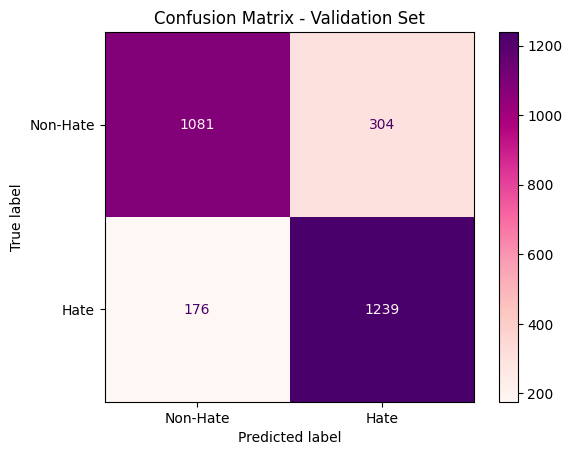

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_val = confusion_matrix(y_validation, y_validation_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Non-Hate", "Hate"])
disp.plot(cmap="RdPu")
plt.title("Confusion Matrix - Validation Set")
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [68]:
X_test = df_test['text']
X_test_transformed = vectorizer.transform(X_test)
y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_test = df_test['label']

accuracy = accuracy_score(y_test, y_test_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)

print("Test Set Metrics")
print("Accuracy:", round(100*accuracy, 2), "%")
print("Balanced Accuracy:", round(100*balanced_accuracy, 2), "%")
print("Precision:", round(100*precision, 2), "%")

Test Set Metrics
Accuracy: 82.49 %
Balanced Accuracy: 82.52 %
Precision: 79.45 %


22. Create a confusion matrix using the **test dataset**

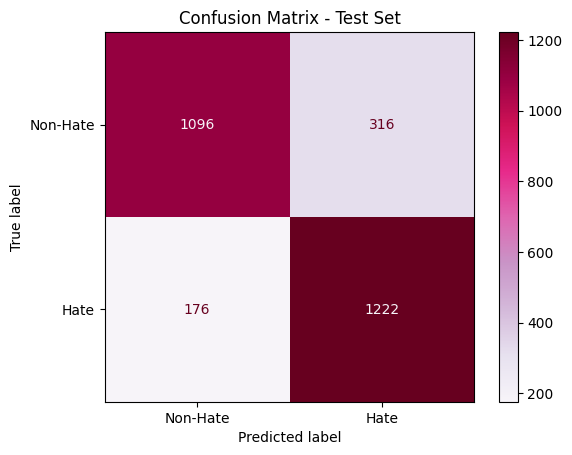

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm_test = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Non-Hate", "Hate"])
disp.plot(cmap="PuRd")
plt.title("Confusion Matrix - Test Set")
plt.show()

## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [80]:
def predict_sentence(sentence):
    sentence_clean = sentence.lower()
    sentence_clean = re.sub(r"http\S+|www\S+|https\S+", "", sentence_clean)
    sentence_clean = re.sub(r"[^a-z\s]", "", sentence_clean)
    words = sentence_clean.split()
    words = [w for w in words if w not in stop_words]
    sentence_clean = " ".join(words)

    vec = vectorizer.transform([sentence_clean])
    prediction = model.predict(vec)[0]
    return prediction

test_input = "i love pilipinas"
prediction = predict_sentence(test_input)

print("Input:", test_input)
print("Prediction:", prediction)

Input: i love pilipinas
Prediction: 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [82]:
def predict_sentence(sentence):
    sentence_clean = sentence.lower()
    sentence_clean = re.sub(r"http\S+|www\S+|https\S+", "", sentence_clean)
    sentence_clean = re.sub(r"[^a-z\s]", "", sentence_clean)
    words = sentence_clean.split()
    words = [w for w in words if w not in stop_words]
    sentence_clean = " ".join(words)

    vec = vectorizer.transform([sentence_clean])
    prediction = model.predict(vec)[0]
    return prediction

test_input = "dutertard ka kasi"
prediction = predict_sentence(test_input)

print("Input:", test_input)
print("Prediction:", prediction)

Input: dutertard ka kasi
Prediction: 1
